In [1]:
# import required packages
from fastai.tabular import *

In [2]:
# path to project directory
path = Path()

In [3]:
# read in training dataset
# created using fpl_data_clean notebook
train_df = pd.read_csv(path/'data/train_v3.csv', index_col=0, dtype={'season':str})

In [4]:
train_df.tail()

player  gw  position  minutes               team  \
90432      Tommy_Doyle  38         3        0    Manchester City   
90433     Joseph_Anang  38         1        0    West Ham United   
90434     Erik_Pieters  38         2       90            Burnley   
90435  Japhet_Tanganga  38         2        0  Tottenham Hotspur   
90436   Ravel_Morrison  38         3        0   Sheffield United   

                  opponent_team  relative_market_value_team  \
90432                   Norwich                    2.430397   
90433               Aston Villa                    0.709989   
90434  Brighton and Hove Albion                    0.370648   
90435            Crystal Palace                    1.604904   
90436               Southampton                    0.348678   

       relative_market_value_opponent_team  was_home  total_points  ...  \
90432                             0.327574      True             0  ...   
90433                             0.553818      True             0  ...   
90434                             0.541184      True             3  ...   
90435                             0.430493     False             0  ...   
90436                             0.526987     False             0  ...   

       team_a_score  team_h_score  threat  transfers_balance  transfers_in  \
90432             0             5     0.0                 -2            22   
90433             1             1     0.0                 70           270   
90434             2             1     2.0             139816        144388   
90435             1             1     0.0               7999         14840   
90436             1             3     0.0                -23             7   

       transfers_out  yellow_cards          kickoff_time  season  play_proba  
90432             24             0  2020-07-26T15:00:00Z    1920         1.0  
90433            200             0  2020-07-26T15:00:00Z    1920         1.0  
90434           4572             1  2020-07-26T15:00:00Z    1920         1.0  
90435           6841             0  2020-07-26T15:00:00Z    1920         1.0  
90436             30             0  2020-07-26T15:00:00Z    1920         0.0  

[5 rows x 35 columns]

In [5]:
# exclude zero minute rows
#train_df = train_df[train_df['minutes'] != 0].reset_index()

In [6]:
train_df.shape

(90437, 35)

In [7]:
# find the latest gameweek
last_gw = train_df['gw'][train_df['season'] == '1920'].max()

if np.isnan(last_gw): 
    next_gw = 1 
else: 
    next_gw = last_gw + 1
    
next_gw

39

In [8]:
# find validation cut point - index for 18-19 season second half (gw 19)
#valid_start = train_df[(train_df['gw'] > 18) & (train_df['season'] == '1819')].index.min()
# or take validation as same as current prediction set
# valid_start = train_df[(train_df['season'] == '1819') & (train_df['gw'] == next_gw)].index.min()
# valid_end = train_df[(train_df['season'] == '1920') & (train_df['gw'] == 1)].index.min()
#valid_end = train_df.index.max()

valid_start = train_df[(train_df['gw'] > 18) & (train_df['season'] == '1920')].index.min()
valid_end = train_df.index.max()

In [9]:
# set validation dataset based on indexes calculated earlier
valid_idx = range(valid_start, valid_end)

In [10]:
# check data types
train_df.dtypes

player                                  object
gw                                       int64
position                                 int64
minutes                                  int64
team                                    object
opponent_team                           object
relative_market_value_team             float64
relative_market_value_opponent_team    float64
was_home                                  bool
total_points                             int64
assists                                  int64
bonus                                    int64
bps                                      int64
clean_sheets                             int64
creativity                             float64
goals_conceded                           int64
goals_scored                             int64
ict_index                              float64
influence                              float64
own_goals                                int64
penalties_missed                         int64
penalties_sav

In [11]:
# set categorical and continuous variables for tabular learner
cat_vars = ['player', 'gw', 'position', 'team', 'opponent_team', 'was_home', 'season']
cont_vars = ['minutes', 'relative_market_value_team', 'relative_market_value_opponent_team']#, 'ppg_total', 'points_last_5']

In [12]:
# set dependent variable
dep_var = 'total_points'

In [13]:
# processors - categorify categorical variables and normalize continuous variables
# fill missing not used because new teams are almost certainly well below the league average
procs=[Categorify, Normalize]

In [14]:
# create databunch
data = (TabularList.from_df(train_df, path=path, cat_names=cat_vars, cont_names=cont_vars, procs=procs,)
                .split_by_idx(valid_idx)
                .label_from_df(cols=dep_var, label_cls=FloatList)
                .databunch())

In [15]:
# set range of predictions - minimum to current max
max_y = np.max(train_df['total_points'])
min_y = np.min(train_df['total_points'])
y_range = (torch.tensor([-1, max_y], device=defaults.device))

In [58]:
# instatiate tabular learner
learn = tabular_learner(data, layers=[1000,500], ps=[0.001,0.01], emb_drop=0.04, 
                        y_range=y_range, metrics=rmse)

In [17]:
# take a look at the nueral net architecture
# note that categorical variables all have embeddings (used default embedding sizes)
learn.model

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(1293, 88)
    (1): Embedding(39, 12)
    (2): Embedding(5, 4)
    (3): Embedding(30, 11)
    (4): Embedding(30, 11)
    (5): Embedding(3, 3)
    (6): Embedding(5, 4)
  )
  (emb_drop): Dropout(p=0.04)
  (bn_cont): BatchNorm1d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=136, out_features=1000, bias=True)
    (1): ReLU(inplace)
    (2): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.001)
    (4): Linear(in_features=1000, out_features=500, bias=True)
    (5): ReLU(inplace)
    (6): BatchNorm1d(500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.01)
    (8): Linear(in_features=500, out_features=1, bias=True)
  )
)

In [ ]:
learn.lr_find()

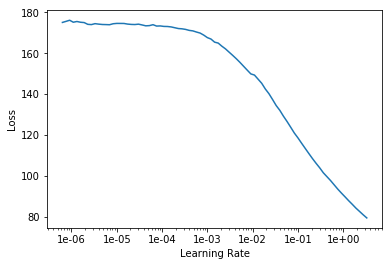

In [166]:
learn.recorder.plot()

In [ ]:
# no market value, latest half season validation
# learn.fit_one_cycle(3, 1.1e-2, wd=0.2)

In [43]:
# market value, latest half season validation
# learn.fit_one_cycle(3, 1.5e-3, wd=0.2)

In [22]:
# no market value, new season validation
# learn.fit_one_cycle(4, 1e-2, wd=0.2)

In [59]:
# CURRENT APPROACH
# market value, new season validation
learn.fit_one_cycle(2, 1e-2, wd=0.2)

In [18]:
# second training run with lower LR
learn.fit_one_cycle(1, 1e-3, wd=0.2)

In [19]:
def r_mse(pred,y): return round(math.sqrt(((pred-y)**2).mean()), 6)

In [60]:
preds,targs = learn.get_preds()
r_mse([val.item() for sublist in preds for val in sublist],array(targs))

1.806723

In [48]:
[val.item() for sublist in preds for val in sublist] - array(targs)

array([4.25294 , 0.071494, 0.141828, 0.251316, ..., 0.143715, 0.120683, 0.568097, 0.102527])

In [47]:
array(targs)

array([-3.,  0.,  0.,  0., ...,  0.,  0.,  3.,  0.], dtype=float32)

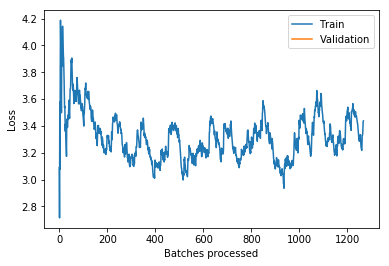

In [19]:
learn.recorder.plot_losses()

In [20]:
# add predictions to the validations set
df_valid = train_df.loc[valid_idx]
df_valid['predicted_points'] = learn.get_preds()[0].data.numpy().T[0]

In [21]:
# look at one team/gameweek
df_valid[(df_valid['team'] == 'Cardiff City') & (df_valid['opponent_team'] == 'Chelsea')].head(10)

Empty DataFrame
Columns: [player, gw, position, minutes, team, opponent_team, relative_market_value_team, relative_market_value_opponent_team, was_home, total_points, assists, bonus, bps, clean_sheets, creativity, goals_conceded, goals_scored, ict_index, influence, own_goals, penalties_missed, penalties_saved, red_cards, saves, selected, team_a_score, team_h_score, threat, transfers_balance, transfers_in, transfers_out, yellow_cards, kickoff_time, season, play_proba, predicted_points]
Index: []

[0 rows x 36 columns]

In [22]:
# look at top predictions
df_valid.sort_values('predicted_points', ascending=False).head(20)

player  gw  position  minutes               team  \
67748              Mohamed_Salah  38         3       90          Liverpool   
67715            Mason_Greenwood  38         4       90  Manchester United   
67802            Raheem_Sterling  38         3       90    Manchester City   
67856              Sergio_Agüero  38         4       90    Manchester City   
67836                 Sadio_Mané  38         3       90          Liverpool   
67811               Riyad_Mahrez  38         3       90    Manchester City   
67457                 Danny_Ings  38         4       75        Southampton   
67784                 Paul_Pogba  38         3       90  Manchester United   
67701            Marcus_Rashford  38         4       90  Manchester United   
67384                Ayoze_Pérez  38         4       90   Newcastle United   
67430          Christian_Eriksen  38         3       90  Tottenham Hotspur   
67473                David_Silva  38         3       77    Manchester City   
67741            Michy_Batshuayi  38         4       88     Crystal Palace   
67365                 Angus_Gunn  38         1       90        Southampton   
67897     Trent_Alexander-Arnold  38         2       90          Liverpool   
67554                Hugo_Lloris  38         1       90  Tottenham Hotspur   
67598              Jesse_Lingard  38         3       90  Manchester United   
67795  Pierre-Emerick_Aubameyang  38         4       90            Arsenal   
67763             Nathan_Redmond  38         3       90        Southampton   
67786    Pedro_Rodríguez Ledesma  38         3       90            Chelsea   

                  opponent_team  relative_market_value_team  \
67748   Wolverhampton Wanderers                    2.177887   
67715              Cardiff City                    2.015531   
67802  Brighton and Hove Albion                    2.540586   
67856  Brighton and Hove Albion                    2.540586   
67836   Wolverhampton Wanderers                    2.177887   
67811  Brighton and Hove Albion                    2.540586   
67457         Huddersfield Town                    0.654624   
67784              Cardiff City                    2.015531   
67701              Cardiff City                    2.015531   
67384                    Fulham                    0.483921   
67430                   Everton                    1.983109   
67473  Brighton and Hove Albion                    2.540586   
67741               Bournemouth                    0.634856   
67365         Huddersfield Town                    0.654624   
67897   Wolverhampton Wanderers                    2.177887   
67554                   Everton                    1.983109   
67598              Cardiff City                    2.015531   
67795                   Burnley                    1.435552   
67763         Huddersfield Town                    0.654624   
67786            Leicester City                    2.540586   

       relative_market_value_opponent_team  was_home  total_points  \
67748                             0.388177      True             3   
67715                             0.183890      True             2   
67802                             0.417745     False             5   
67856                             0.417745     False             6   
67836                             0.388177      True            15   
67811                             0.417745     False            13   
67457                             0.273778      True             5   
67784                             0.183890      True             1   
67701                             0.183890      True             2   
67384                             0.405284     False             7   
67430                             1.039221      True             7   
67473                             0.417745     False             9   
67741                             0.418108      True            13   
67365                             0.273778      True             2   
67897        

In [23]:
np.mean(df_valid.sort_values('predicted_points', ascending=False).head(1000)['predicted_points'])

1.29904043674469

In [24]:
prev_pt_mean = np.mean(df_valid.sort_values('predicted_points', ascending=False).head(1000)['total_points'])
prev_pt_mean

1.3557692307692308

In [25]:
## now we have decided training approach, need to apply to remainder of season
# read in remaining_season.csv
remaining_season_df = pd.read_csv(path/'data/remaining_season.csv', index_col=0)

In [26]:
remaining_season_df.head(50)
#remaining_season_df[remaining_season_df.player == 'Trent_Alexander-Arnold']

gw     team             opponent_team                            player  \
0   38  Arsenal                   Watford                  Shkodran_Mustafi   
1   38  Arsenal                   Watford                   Héctor_Bellerín   
2   38  Arsenal                   Watford                    Sead_Kolasinac   
3   38  Arsenal                   Watford            Ainsley_Maitland-Niles   
4   38  Arsenal                   Watford         Sokratis_Papastathopoulos   
5   38  Arsenal                   Watford                     Nacho_Monreal   
6   38  Arsenal                   Watford                 Laurent_Koscielny   
7   38  Arsenal                   Watford           Konstantinos_Mavropanos   
8   38  Arsenal                   Watford                    Carl_Jenkinson   
9   38  Arsenal                   Watford                       Rob_Holding   
10  38  Arsenal                   Watford         Pierre-Emerick_Aubameyang   
11  38  Arsenal                   Watford               Alexandre_Lacazette   
12  38  Arsenal                   Watford                    Edward_Nketiah   
13  38  Arsenal                   Watford                        Bernd_Leno   
14  38  Arsenal                   Watford                        Mesut_Özil   
15  38  Arsenal                   Watford                Henrikh_Mkhitaryan   
16  38  Arsenal                   Watford                      Granit_Xhaka   
17  38  Arsenal                   Watford                    Lucas_Torreira   
18  38  Arsenal                   Watford                    Mohamed_Elneny   
19  38  Arsenal                   Watford                  Matteo_Guendouzi   
20  38  Arsenal                   Watford        David_Luiz Moreira Marinho   
21  38  Arsenal                   Watford                 Emiliano_Martínez   
22  38  Arsenal                   Watford                    Calum_Chambers   
23  38  Arsenal                   Watford         Daniel_Ceballos Fernández   
24  38  Arsenal                   Watford                     Cédric_Soares   
25  38  Arsenal                   Watford                      Nicolas_Pépé   
26  38  Arsenal                   Watford                      Reiss_Nelson   
27  38  Arsenal                   Watford                    Joseph_Willock   
28  38  Arsenal                   Watford  Gabriel Teodoro_Martinelli Silva   
29  38  Arsenal                   Watford                    Kieran_Tierney   
30  38  Arsenal                   Watford                       Bukayo_Saka   
31  38  Arsenal                   Watford                  Emile_Smith Rowe   
32  38  Arsenal                   Watford                Tyreece_John-Jules   
33  38  Arsenal                   Watford                        Pablo_Marí   
34  38  Arsenal                   Watford                       Zech_Medley   
35  38  Arsenal                   Watford                        Matt_Macey   
36  38  Arsenal                   Watford                     Matthew_Smith   
37  38  Burnley  Brighton and Hove Albion                           Ben_Mee   
38  38  Burnley  Brighton and Hove Albion                   James_Tarkowski   
39  38  Burnley  Brighton and Hove Albion                    Matthew_Lowton   
40  38  Burnley  Brighton and Hove Albion                     Phil_Bardsley   
41  38  Burnley  Brighton and Hove Albion                    Charlie_Taylor   
42  38  Burnley  Brighton and Hove Albion                        Kevin_Long   
43  38  Burnley  Brighton and Hove Albion                        Ben_Gibson   
44  38  Burnley  Brighton and Hove Albion                     Ashley_Barnes   
45  38  Burnley  Brighton and Hove Albion                        Chris_Wood   
46  38  Burnley  Brighton and Hove Albion                       Matej_Vydra   
47  38  Burnley  Brighton and Hove Albion                         Nick_Pope   
48  38  Burnley  Brighton and Hove Albion                          Joe_Hart   
49  38  Burnley  Brighton and Hove Albion           Jo

In [27]:
# create new databunch, with remaining season as test set
# and using all available data i.e. no validation
data = (TabularList.from_df(train_df, path=path, cat_names=cat_vars, cont_names=cont_vars, procs=procs,)
                .split_none()
                .label_from_df(cols=dep_var, label_cls=FloatList)
                .add_test(TabularList.from_df(remaining_season_df, path=path, cat_names=cat_vars, cont_names=cont_vars))
                .databunch())

In [28]:
# instatiate new tabular learner
# learn = tabular_learner(data, layers=[1000,500], ps=[0.001,0.01], emb_drop=0.04, 
#                         y_range=y_range, metrics=rmse)

In [29]:
# train as before
# learn.fit_one_cycle(2, 1e-2, wd=0.2)

In [30]:
# learn.fit_one_cycle(1, 1e-3, wd=0.2)

In [31]:
# get predictions
# test_preds=learn.get_preds(DatasetType.Test)
# remaining_season_df['predicted_points'] = test_preds[0].data.numpy().T[0]

In [32]:
# check mean of top predictions to see if it's reasonably close to previous season's actuals
# re-run if not - not ideal but at the moment the training often over-predicts top players
# pred_pt_mean = np.mean(remaining_season_df.sort_values('predicted_points', ascending=False).head(1000)['predicted_points'])
# pred_pt_mean

In [33]:
while True:
    # instatiate new tabular learner
    learn = tabular_learner(data, layers=[1000,500], ps=[0.001,0.01], emb_drop=0.04, 
                            y_range=y_range, metrics=rmse)
    
    # train as before
    learn.fit_one_cycle(2, 1e-2, wd=0.2)
    learn.fit_one_cycle(1, 1e-3, wd=0.2)

    # get predictions
    test_preds=learn.get_preds(DatasetType.Test)
    remaining_season_df['predicted_points'] = test_preds[0].data.numpy().T[0]
    
    # check mean of top predictions to see if it's reasonably close to previous season's actuals
    # re-run if not - not ideal but at the moment the training often over-predicts top players
    pred_pt_mean = np.mean(remaining_season_df.sort_values('predicted_points', ascending=False).head(1000)['predicted_points'])
    
    if abs((prev_pt_mean - pred_pt_mean) / prev_pt_mean) < 0.05:
        print("Mean of top 1000 predictions: {:.4}".format(pred_pt_mean))
        break
    else:
        print("{:.4}...retraining...".format(pred_pt_mean))

Mean of top 1000 predictions: 1.288


In [34]:
remaining_season_df.shape

(665, 13)

In [35]:
# quick look
remaining_season_df.sort_values(by='predicted_points', ascending=False).head(20)

gw               team             opponent_team  \
580  38          Liverpool          Newcastle United   
10   38            Arsenal                   Watford   
443  38  Tottenham Hotspur            Crystal Palace   
205  38    Manchester City                   Norwich   
581  38          Liverpool          Newcastle United   
47   38            Burnley  Brighton and Hove Albion   
21   38            Arsenal                   Watford   
578  38          Liverpool          Newcastle United   
447  38  Tottenham Hotspur            Crystal Palace   
208  38    Manchester City                   Norwich   
570  38          Liverpool          Newcastle United   
172  38     Leicester City         Manchester United   
209  38    Manchester City                   Norwich   
571  38          Liverpool          Newcastle United   
535  38  Manchester United            Leicester City   
206  38    Manchester City                   Norwich   
521  38  Manchester United            Leicester City   
11   38            Arsenal                   Watford   
572  38          Liverpool          Newcastle United   
134  38            Everton               Bournemouth   

                            player  position  price  play_proba  was_home  \
580                  Mohamed_Salah         3   12.5         1.0     False   
10       Pierre-Emerick_Aubameyang         4   10.9         1.0      True   
443                     Harry_Kane         4   11.0         1.0     False   
205      Gabriel Fernando_de Jesus         4    9.9         1.0      True   
581                     Sadio_Mané         3   12.1         1.0     False   
47                       Nick_Pope         1    5.2         1.0      True   
21               Emiliano_Martínez         1    4.4         1.0      True   
578          Alisson_Ramses Becker         1    6.2         1.0     False   
447                  Heung-Min_Son         3    9.7         1.0     False   
208                Raheem_Sterling         3   12.0         1.0      True   
570               Andrew_Robertson         2    7.0         1.0     False   
172                    Jamie_Vardy         4    9.7         1.0      True   
209                Kevin_De Bruyne         3   10.6         1.0      True   
571         Trent_Alexander-Arnold         2    7.7         1.0     False   
535  Bruno Miguel_Borges Fernandes         3    9.0         1.0     False   
206      Ederson_Santana de Moraes         1    6.1         1.0      True   
521                Anthony_Martial         3    8.5         1.0     False   
11             Alexandre_Lacazette         4    9.2         1.0      True   
572                Virgil_van Dijk         2    6.5         1.0     False   
134                    Lucas_Digne         2    5.9         1.0      True   

     relative_market_value_team  relative_market_value_opponent_team  season  \
580                    2.451453                             0.603446    1920   
10                     1.496432                             0.504811    1920   
443                    1.737985                             0.429399    1920   
205                    2.468858                             0.311992    1920   
581                    2.451453                             0.603446    1920   
47                     0.360601                             0.503369    1920   
21                     1.496432                             0.504811    1920   
578                    2.451453                             0.603446    1920   
447                    1.737985                             0.429399    1920   
208                    2.468858                             0.311992    1920   
570                    2.451453                             0.603446    1920   
172                    1.044531                             1.640220    1920   
209                    2.468858                             0.311992    1920   
571                    2.451453                             0.603446    1920   
535       

In [36]:
# rename previous week's predictions file
# generate previous week's filename
last_gw = next_gw - 1
filename = 'predictions_gw' + str(last_gw) + '.csv'
! mv predictions.csv $filename

In [37]:
# write to predictions.csv
## RENAME PREVIOUS WEEK FIRST
predictions = remaining_season_df[['gw', 'player', 'team', 'position', 'price', 'play_proba', 'predicted_points']]
predictions.to_csv('predictions.csv')